# Creating New Benchmarks

Here we give a demonstration of how to create a new benchmark based on experimental data. We call these type of benchmarks emulators, and they use the class `ExperimentalEmulator`. 

Emulators contain machine learning models, which can learn patterns from experimental data. These models can then be used to predict the outcomes of reactions at conditions that have not been tested in the lab.

Emulators are most applicable when a kinetic model is not available. This is common with reactions where catalysts, bases and acids are still being chosen.


As an example, we are going to create a benchmark for the Suzuki-Miyaura Cross-Coupling reaction in [Reizman et al. (2016)](https://doi.org/10.1039/C6RE00153J).


![Image from Hone et al.](../_static/suzuki_reizman.gif) 

Scheme reproduced from the paper.

## Google Colab

If you would like to follow along with this tutorial, you can open it in Google Colab using the button below.

You will need to run the following cell to make sure Summit and all its dependencies are installed. If prompted, restart the runtime.

In [ ]:
!pip install summit

## Imports 

Let's first import the needed parts of Summit.

In [2]:
from summit.benchmarks import ExperimentalEmulator
from summit.domain import *
from summit.utils.dataset import DataSet
import pkg_resources
import pathlib

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create the domain

We first need to create a :class:`~summit.domain.Domain`. A domain specifies the aspects of the reaction we will be optimizing. In optimization speak, these are the decision variables (those that are manipulated), constraints and objectives for a benchmark.

In [4]:
domain = Domain()

Above, we instantiate a new domain without any variables. Here, we are going to manipulate the catalyst, catalyst loading, base stoichiometry and temperature. Our objectives are to maximise yield and minimise turn over number (TON). We can use the increment operator `+=` to add variables to the domain. There are no constraints.

In [5]:
# Decision variables
des_1 = "Catalyst type - different ligands"
domain += CategoricalVariable(
    name="catalyst",
    description=des_1,
    levels=[
        "P1-L1",
        "P2-L1",
        "P1-L2",
        "P1-L3",
        "P1-L4",
        "P1-L5",
        "P1-L6",
        "P1-L7",
    ],
)

We specify the catalyst as a `CategoricalVariable`, which can encapsulate discrete decisions such as choosing a catalyst, base, or acid from a list of potential options. We pass the list of potential options to the `levels` keyword argument. Our data should only include one of the catalysts in `levels`.

Below, we use `ContinuousVariable` to specify the rest of the decision variables. Each has `bounds`, which represent the minimum and maximum values of each variable.

In [6]:
des_2 = "Residence time in seconds (s)"
domain += ContinuousVariable(name="t_res", description=des_2, bounds=[60, 600])

des_3 = "Reactor temperature in degrees Celsius (ºC)"
domain += ContinuousVariable(
    name="temperature", description=des_3, bounds=[30, 110]
)

des_4 = "Catalyst loading in mol%"
domain += ContinuousVariable(
    name="catalyst_loading", description=des_4, bounds=[0.5, 2.5]
)


Finally, we specify the objectives. We use `ContinuousVariable` again, but set `is_objective` to `True` and specify whether to maximize (or minimize) each objective.

In [7]:
# Objectives
des_5 = "Yield"
domain += ContinuousVariable(
    name="yield",
    description=des_5,
    bounds=[0, 100],
    is_objective=True,
    maximize=True,
)


des_6 = (
    "Turnover number - moles product generated divided by moles catalyst used"
)
domain += ContinuousVariable(
    name="ton",
    description=des_6,
    bounds=[0, 200],
    is_objective=True,
    maximize=True,
)



When working inside a Jupyter Notebook, we can view the domain by putting it at the end of a cell and pressing enter.

In [8]:
domain

Name,Type,Description,Values
catalyst,"categorical, input",Catalyst type - different ligands,8 levels
t_res,"continuous, input",Residence time in seconds (s),"[60,600]"
temperature,"continuous, input",Reactor temperature in degrees Celsius (ºC),"[30,110]"
catalyst_loading,"continuous, input",Catalyst loading in mol%,"[0.5,2.5]"
yield,"continuous, maximize objective",Yield,"[0,100]"
ton,"continuous, maximize objective",Turnover number - moles product generated divided by moles catalyst used,"[0,200]"


## Load Data

We now load in the data from past experiments, which we will use to train the emulator. Here, we import the data that we already have in the Summit package, but any data available in CSV format would work. 

In [9]:
# Get the data already available in Summit
DATA_PATH = pathlib.Path(pkg_resources.resource_filename("summit", "benchmarks/data"))

# Read in data into a DataSEt.
ds = DataSet.read_csv(DATA_PATH / "reizman_suzuki_case_1.csv",)

Note that we are using a :class:`~summit.dataset.Dataset`. In the CSV, it is essential that the columns match the domain and an extra row is added below each column name with the word DATA (see [here](https://github.com/sustainable-processes/summit/blob/master/summit/benchmarks/data/reizman_suzuki_case_1.csv) for an example).

## Train the Emulator

Now we only need two lines to train the experimental emulator!  We first instantiate `ExperimentalEmulator` passing in the dataset, domain and a name for the model.  Next we train it with two-fold [cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/) and a test set size of 25%.

This step will take some time. Change verbose to 1 if you want streaming updates of the training.

In [10]:
emul = ExperimentalEmulator(model_name='my_reizman', domain=domain, dataset=ds)
emul.train(max_epochs=1000, cv_fold=2, test_size=0.1, verbose=0)

{'fit_time': array([9.62368822, 9.36741114, 8.81644607, 8.90442324, 8.75493693]),
 'score_time': array([0.00828385, 0.00569177, 0.00601172, 0.00571394, 0.00531006]),
 'val_r2': array([0.73406495, 0.79712705, 0.87009207, 0.8853467 , 0.71850636]),
 'val_neg_root_mean_squared_error': array([-15.48383141, -12.27886391, -10.41021824,  -8.35124302,
        -12.52505112])}

The training returns a `scores` dictionary from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate), which contains the results from each cross-validation fold. It might be difficult to understand these scores, so we show some more intuitive evaluation methods next. 

## Evaluate Emulator

A [parity plot](https://en.wikipedia.org/wiki/Parity_plot) shows experimental data against model predictions. We can do this for both the train and test sets. The $r^2$ score is shown, which varies between 0 and 1 with 1 being perfect fit.

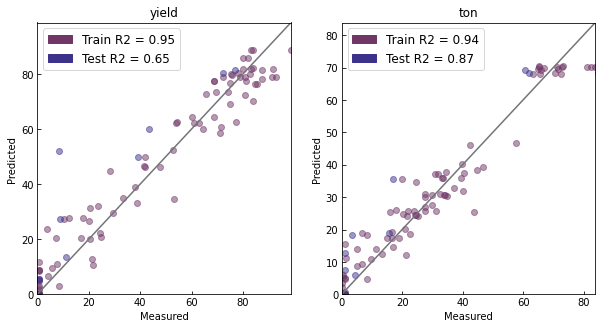

In [11]:
fig, ax = emul.parity_plot(include_test=True)

We can also try running virtual experiments using the benchmark to see if they match our expectations.

In [12]:
conditions = [["P1-L1", 60, 100, 1.0]]
conditions = DataSet(conditions, columns=[v.name for v in domain.input_variables])
emul.run_experiments(conditions)

,catalyst,t_res,temperature,catalyst_loading,yield,ton,computation_t,experiment_t,strategy
0,P1-L1,60,100,1.0,30.521872,29.758484,0.0,0.034721,NaN


## Saving and Loading Emulators

We can save the trained emulator to disk, so we can reuse it later. The `save` method will do two things: 

- Create a JSON file `model_name.json` (where model_name is the name used when ExperimentalEmulator is called). The JSON file contains the domain, any experiments run using the emulator, and some important hyperparameters (e.g., the mean and standard deviation used for normalization).
- Create several `.pt` files with the weights of the models trained using cross validation.

We simply specify a directory where the files should be saved.

In [13]:
emul.save(save_dir="emulators_tutorial")

We can load the saved emulator and use it as expected.

In [14]:
emul_new = ExperimentalEmulator.load(model_name="my_reizman", save_dir="emulators_tutorial")
emul_new.run_experiments(conditions)

,catalyst,t_res,temperature,catalyst_loading,yield,ton,computation_t,experiment_t,strategy
0,P1-L1,60,100,1.0,30.521872,29.758484,0.0,0.027989,NaN
